Downloading the trial records from OldBailey using the API

In [65]:
import requests
import os
import time
from google.colab import drive

#store text files
save_path = '/content/oldbailey'
os.makedirs(save_path, exist_ok=True)

# API endpoints
SEARCH_API = "https://www.dhi.ac.uk/api/data/oldbailey_record"
SINGLE_RECORD_API = "https://www.dhi.ac.uk/api/data/oldbailey_record_single"

#parameters
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept': 'application/json'
}

def get_sample_ids(total_records=20):
    """Retrieve trial record IDs (starting with 't') from the API with pagination"""
    print("Fetching trial record IDs...")
    all_ids = []
    page_size = 10
    current_from = 0

    while len(all_ids) < total_records:
        params = {
            'size': page_size,
            'from': current_from,
            'text': '*'
        }

        response = requests.get(SEARCH_API, params=params, headers=headers)

        if response.status_code != 200:
            print(f"Error fetching IDs: {response.status_code}")
            break

        data = response.json()
        hits = data['hits']['hits']

        if not hits:
            break  # No more records

        # Extract only trial IDs (starting with 't') from current page
        page_ids = [
            hit['_source']['idkey']
            for hit in hits
            if hit['_source']['idkey'].startswith('t')
        ]
        all_ids.extend(page_ids)

        # Update pagination parameters
        current_from += page_size

        # Check if we've reached the requested total
        remaining = total_records - len(all_ids)
        if remaining <= 0:
            break

        # Adjust page size for final request if needed
        if remaining < page_size:
            page_size = remaining

        time.sleep(1)

    return all_ids[:total_records]  # Return exactly requested number

def save_records(record_ids):
    """Save individual records as xml files"""
    for i, record_id in enumerate(record_ids, 1):
        print(f"Downloading record {i}: {record_id}")
        params = {'idkey': record_id}

        try:
            response = requests.get(SINGLE_RECORD_API, params=params, headers=headers)
            if response.status_code == 200:
                data = response.json()
                text_content = data['hits']['hits'][0]['_source']['xml']

                # Clean filename and save
                safe_id = record_id.replace('/', '_')
                filename = os.path.join(save_path, f"{safe_id}.xml")
                with open(filename, 'w', encoding='utf-8') as f:
                    f.write(text_content)
                print(f"Successfully saved: {filename}")
            else:
                print(f"Failed to download {record_id} (Status: {response.status_code})")

            # Short pause between requests
            time.sleep(1)

        except Exception as e:
            print(f"Error processing {record_id}: {str(e)}")

#execution
sample_ids = get_sample_ids(40)  # Request number of trial records

if sample_ids:
    # print("\nFound these trial records:")
    # for id in sample_ids:
    #     print(f"- {id}")

    save_records(sample_ids)

    # # Optional: Save to Google Drive
    # drive.mount('/content/drive')
    # !cp -r {save_path} "/content/drive/MyDrive/"
    # print("\nFiles copied to Google Drive!")
else:
    print("No trial records found to download")

Fetching trial record IDs...
Successfully saved: /content/oldbailey/t16740429-1.xml
Successfully saved: /content/oldbailey/t16740429-2.xml
Successfully saved: /content/oldbailey/t16740429-3.xml
Successfully saved: /content/oldbailey/t16740429-4.xml
Successfully saved: /content/oldbailey/t16740429-5.xml
Successfully saved: /content/oldbailey/t16740429-6.xml
Successfully saved: /content/oldbailey/t16740429-7.xml
Successfully saved: /content/oldbailey/t16740429-8.xml
Successfully saved: /content/oldbailey/t16740429-9.xml
Successfully saved: /content/oldbailey/t16740717-1.xml
Successfully saved: /content/oldbailey/t16740717-2.xml
Successfully saved: /content/oldbailey/t16740717-3.xml
Successfully saved: /content/oldbailey/t16740717-4.xml
Successfully saved: /content/oldbailey/t16740717-5.xml
Successfully saved: /content/oldbailey/t16740717-6.xml
Successfully saved: /content/oldbailey/t16740909-1.xml
Successfully saved: /content/oldbailey/t16740909-2.xml
Successfully saved: /content/oldbail

**Sample inputs for 1 trial, 1 day, 1 month**

In [66]:

# Input for one trial
one_trial = ['/content/oldbailey/t16740429-7.xml']

# Input for one day (all trials on July 17, 1674)
one_day = [
    '/content/oldbailey/t16740717-1.xml',
    '/content/oldbailey/t16740717-2.xml',
    '/content/oldbailey/t16740717-3.xml',
    '/content/oldbailey/t16740717-4.xml',
    '/content/oldbailey/t16740717-5.xml',
    '/content/oldbailey/t16740717-6.xml'
]

# Input for one month (all trials in April 1674)
one_month = [
    '/content/oldbailey/t16740429-1.xml',
    '/content/oldbailey/t16740429-2.xml',
    '/content/oldbailey/t16740429-3.xml',
    '/content/oldbailey/t16740429-4.xml',
    '/content/oldbailey/t16740429-5.xml',
    '/content/oldbailey/t16740429-6.xml',
    '/content/oldbailey/t16740429-7.xml',
    '/content/oldbailey/t16740429-8.xml',
    '/content/oldbailey/t16740429-9.xml'
]

Parse the XML files

In [67]:
import os
import re
import xml.etree.ElementTree as ET
import time

def parse_trial(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    trial_data = {
        "defendants": [],
        "verdicts": []
    }

    defendant_genders = {}
    for pers in root.findall(".//persName[@type='defendantName']"):
        defendant_id = pers.get("id")  # Get the defendant's ID
        gender = pers.find("interp[@type='gender']")
        gender_value = gender.get("value") if gender is not None else "unknown"
        trial_data["defendants"].append(gender_value)
        defendant_genders[defendant_id] = gender_value

    # Extract guilty verdicts and associate them with defendant genders
    for verdict in root.findall(".//rs[@type='verdictDescription']"):
        if verdict.find("interp[@type='verdictCategory']").get("value") == "guilty":
            verdict_id = verdict.get("id")  # Get the verdict ID
            # Find the corresponding <join> element for this verdict
            for join_element in root.findall(".//join[@result='criminalCharge']"):
                targets = join_element.get("targets").split()
                if verdict_id in targets:

                    for target in targets:
                        if "defend" in target:  # Find the defendant ID in the targets
                            defendant_id = target
                            if defendant_id in defendant_genders:
                                trial_data["verdicts"].append(defendant_genders[defendant_id])

    return trial_data

Using lists to count frequencies

> the first one returns results by each trial like [(1, 1, 0), (1, 1, 0), (3, 3, 0)]




In [68]:
def count_frequencies_list(trial_files):
    # Initialize counters
    defendant_counts = [0, 0, 0]  # [total, men, women]
    verdict_counts = [0, 0, 0]    # [total, men, women]

    for file in trial_files:
        data = parse_trial(file)

        # Update defendant counts
        defendant_counts[0] += len(data["defendants"])  # Total defendants
        defendant_counts[1] += data["defendants"].count("male")  # Male defendants
        defendant_counts[2] += data["defendants"].count("female")  # Female defendants

        # Update verdict counts (only guilty)
        verdict_counts[0] += len(data["verdicts"])  # Total guilty verdicts
        verdict_counts[1] += data["verdicts"].count("male")  # Male guilty verdicts
        verdict_counts[2] += data["verdicts"].count("female")  # Female guilty verdicts


    return defendant_counts, verdict_counts

Using Dictionaries to count frequencies

In [69]:
def count_frequencies_dict(trial_files):

    # Initialize counters
    defendant_counts = {"total": 0, "male": 0, "female": 0}
    verdict_counts = {"total": 0, "male": 0, "female": 0}

    for file in trial_files:
        data = parse_trial(file)

        # Update defendant counts
        defendant_counts["total"] += len(data["defendants"])
        defendant_counts["male"] += data["defendants"].count("male")
        defendant_counts["female"] += data["defendants"].count("female")

        # Update verdict counts (only guilty)
        verdict_counts["total"] += len(data["verdicts"])
        verdict_counts["male"] += data["verdicts"].count("male")
        verdict_counts["female"] += data["verdicts"].count("female")

    return defendant_counts, verdict_counts

Run the counter and visualize the runtime

In [70]:
inputs = [one_trial, one_day, one_month]

for input in inputs:
    print("Input:", (input))
    # Timing the list-based approach
    start_time_list = time.time()
    defendant_counts_list, verdict_counts_list = count_frequencies_list(input)
    time_list = time.time() - start_time_list

    # Timing the dictionary-based approach
    start_time_dict = time.time()
    defendant_counts_dict, verdict_counts_dict = count_frequencies_dict(input)
    time_dict = time.time() - start_time_dict

    print("Defendant counts (list):", defendant_counts_list)
    print("Total:", defendant_counts_list[0], ", Men:", defendant_counts_list[1], ", Women:", defendant_counts_list[2])
    print("Verdict counts (list):", verdict_counts_list)
    print("Total:", verdict_counts_list[0], ", Men:", verdict_counts_list[1], ", Women:", verdict_counts_list[2])
    print("Execution time (list):", time_list, "seconds")

    print("Defendant counts (dict):", defendant_counts_dict)
    print("Verdict counts (dict):", verdict_counts_dict)
    print("Execution time (dict):", time_dict, "seconds")
    print("\n")

Input: ['/content/oldbailey/t16740429-7.xml']
Defendant counts (list): [2, 2, 0]
Total: 2 , Men: 2 , Women: 0
Verdict counts (list): [2, 2, 0]
Total: 2 , Men: 2 , Women: 0
Execution time (list): 0.0005502700805664062 seconds
Defendant counts (dict): {'total': 2, 'male': 2, 'female': 0}
Verdict counts (dict): {'total': 2, 'male': 2, 'female': 0}
Execution time (dict): 0.00024700164794921875 seconds


Input: ['/content/oldbailey/t16740717-1.xml', '/content/oldbailey/t16740717-2.xml', '/content/oldbailey/t16740717-3.xml', '/content/oldbailey/t16740717-4.xml', '/content/oldbailey/t16740717-5.xml', '/content/oldbailey/t16740717-6.xml']
Defendant counts (list): [6, 5, 1]
Total: 6 , Men: 5 , Women: 1
Verdict counts (list): [5, 4, 1]
Total: 5 , Men: 4 , Women: 1
Execution time (list): 0.0014002323150634766 seconds
Defendant counts (dict): {'total': 6, 'male': 5, 'female': 1}
Verdict counts (dict): {'total': 5, 'male': 4, 'female': 1}
Execution time (dict): 0.004733562469482422 seconds


Input:

Plotting

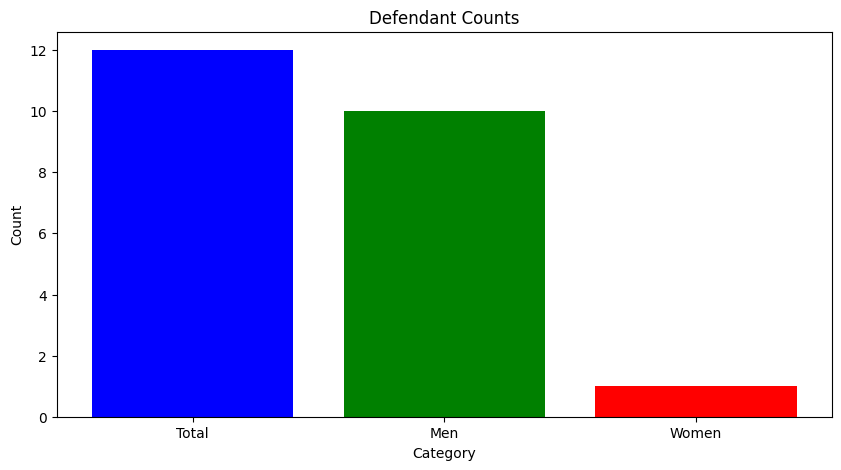

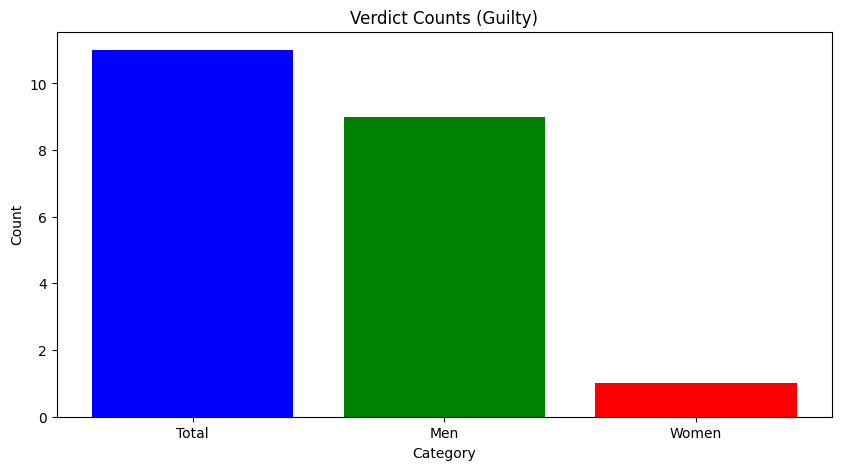

In [71]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
defendant_counts_list, verdict_counts_list = count_frequencies_list(one_month)

# Labels for the bars
labels = ["Total", "Men", "Women"]

# Create a bar graph for defendant counts
plt.figure(figsize=(10, 5))
plt.bar(labels, defendant_counts_list, color=['blue', 'green', 'red'])
plt.title("Defendant Counts")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Create a bar graph for verdict counts
plt.figure(figsize=(10, 5))
plt.bar(labels, verdict_counts_list, color=['blue', 'green', 'red'])
plt.title("Verdict Counts (Guilty)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()